<a href="https://colab.research.google.com/github/durml91/Personal/blob/main/Transformer_implementation_IV%20-%20Training_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Transformer (Encoder-Decoder) Implementation**

## Installs and Imports

*Nvidia CUDA version check*

In [ ]:
# !nvcc --version
# !cat /usr/local/cuda/version.txt
# !cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

**Install datasets before updating JAX**

In [ ]:
!pip install datasets[jax]
!pip install tokenizers
!pip install transformers
!pip install einops
!pip install equinox
!pip install torchmetrics

In [ ]:
!pip install jaxlib==0.4.13+cuda11.cudnn86 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html # [cuda]

#!pip install -U jax jaxlib # [cpu]

*Restart runtime here!*

In [ ]:
import jax
import jax.random as jr
import jax.numpy as jnp

import einops

import equinox as eqx

import optax

import tqdm
from tqdm import notebook as tqdm

import functools

from typing import Dict, List, Mapping, Optional, Callable
from jaxtyping import Array, Float, Int

import math

import numpy as np

import datasets
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from matplotlib.pylab import plt

from torchmetrics.text import WordErrorRate, CharErrorRate, BLEUScore
from torch.utils import data

from pickle import dump, load
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

*Check VM is using GPU accelerator*

In [ ]:
jax.default_backend()

'gpu'

**Random key generation**

In [ ]:
rand_key = jr.PRNGKey(2023)

### Transformer

**Generic equinox module for GELU**

In [ ]:
class Lambda(eqx.Module):

    fn: Callable

    def __call__(self, x, *, key=None):
        return self.fn(x)

**Attention**

In [ ]:
class AttentionBlock(eqx.Module):

    attention: eqx.nn.MultiheadAttention
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=d_model,
            use_query_bias=True,
            use_key_bias=True,
            use_value_bias=True,
            use_output_bias=True,
            dropout_p=attention_dropout_rate,
            key=key,
        )

        self.dropout = eqx.nn.Dropout(dropout_rate)

    @eqx.filter_jit
    def causal_attention_mask(self, q_shape, kv_shape, pad: bool):
        if pad == True:
            #print("causal - padding")
            mask = jnp.ones((q_shape, kv_shape), dtype=float)
            mask = jnp.tril(mask, k=0)
            return mask == 1
        else:
            #print("causal - no padding")
            mask = jnp.ones((q_shape, kv_shape), dtype=float)
            mask = jnp.tril(mask, k=0) == 1
            mask = jnp.expand_dims(mask, axis=-3)
            mask = jnp.where(mask, 1.0, 0.0)
            return jnp.repeat(mask, repeats=self.num_heads, axis=-3)


    @eqx.filter_jit
    def make_attention_mask(
        self, q_pad_mask: Array = jnp.array(()), kv_pad_mask: Array = jnp.array(()), look_ahead_mask: bool = False, inf_shape: int = None
    ) -> Float[Array, "num_heads query_seq_len kv_seq_len"]:

        if q_pad_mask is None:
            #print("cross attn for inf")
            mask = einops.repeat(kv_pad_mask, " a b -> (a q) b", q = inf_shape)
            mask = jnp.where(mask, 1.0, 0.0)
            mask = jnp.expand_dims(mask, axis=-3)
            mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)
            return mask

        # creates rectangular padding with q_pad_mask on the vertical and kv_pad_mask on the horizontal!
        padding_mask = jnp.multiply(jnp.expand_dims(q_pad_mask, axis=-1), jnp.expand_dims(kv_pad_mask, axis=-2))
        p_mask = jnp.where(padding_mask, 1.0, 0.0)
        p_mask = jnp.repeat(p_mask, repeats=self.num_heads, axis=-3)
        if look_ahead_mask is True:
            q_shape = q_pad_mask.shape[-1]
            kv_shape = kv_pad_mask.shape[-1]
            cross_attn_mask = padding_mask & jnp.expand_dims(self.causal_attention_mask(q_shape, kv_shape, pad = True), axis=-3)
            cross_attn_mask = jnp.where(cross_attn_mask, 1.0, 0.0)
            cross_attn_mask = jnp.repeat(cross_attn_mask, repeats=self.num_heads, axis=-3)
            return cross_attn_mask   # .astype(jnp.float32)
        else:
            return p_mask  # .astype(jnp.float32)

    def __call__(
        self,
        query: Float[Array, "... d_model"],
        key_: Float[Array, "... d_model"],
        value: Float[Array, "... d_model"],
        q_pad_mask: Array = None,
        kv_pad_mask: Array = None,
        look_ahead_mask: bool = False,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "... d_model"]:


        if q_pad_mask is not None and kv_pad_mask is not None:
            #print("train")
            mask = self.make_attention_mask(q_pad_mask, kv_pad_mask, look_ahead_mask)
        elif q_pad_mask is None and look_ahead_mask == True:
            #print("self_attn - inference")
            mask = self.causal_attention_mask(query.shape[-2], key_.shape[-2], pad = False)
        elif q_pad_mask is None and kv_pad_mask is not None:
            #print("cross_attn - inference")
            mask = self.make_attention_mask(q_pad_mask, kv_pad_mask, inf_shape = query.shape[-2])
        else:
            #print("none")
            mask = None

        #print(mask)
        #print(jnp.sum(mask))


        attention_key, dropout_key = (
            (None, None) if key is None else jr.split(key)
        )

        attention_output = self.attention(
              query=query,
              key_=key_,
              value=value,
              mask=mask,
              inference=not enable_dropout,
              key=attention_key
        )

        att_drop = self.dropout(attention_output, inference=not enable_dropout, key=dropout_key)

        return att_drop

**MLP Block**

In [ ]:
class FeedForwardBlock(eqx.Module):

    mlp: eqx.nn.Sequential    #could also use MLP if this way is more fiddly
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jr.PRNGKey,
    ):
        linear1, linear2 = jr.split(key)

        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(in_features=d_model, out_features=intermediate_size, key=linear1),
            Lambda(jax.nn.gelu),
            eqx.nn.Linear(in_features=intermediate_size, out_features=d_model, key=linear2)
        ])
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, "... d_model"],
        enable_dropout: bool = True,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        feed_out = jax.vmap(self.mlp)(inputs)
        out_d = self.dropout(feed_out, inference=not enable_dropout, key=key)

        return out_d


**Embedding table**

In [ ]:
class InputEmbeddings(eqx.Module):

  embedding: eqx.nn.Embedding
  d_model: int

  def __init__(
      self,
      d_model: int,
      vocab_size: int,
      key: jr.PRNGKey,
  ):
      self.d_model = d_model
      self.embedding = eqx.nn.Embedding(vocab_size, d_model, key=key)

  def __call__(self, x) -> Float[Array, "seq_len d_model"]:

    return self.embedding(x) * math.sqrt(self.d_model)

**Positional encoding**

In [ ]:
class SinusoidalPosEmb(eqx.Module):
    pos_emb: jax.Array
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        seq_len: int,
        dropout_rate: float
    ):
        self.dropout = eqx.nn.Dropout(dropout_rate)
        half_dim = d_model//2
        pe = jnp.zeros((seq_len, d_model))
        position = einops.repeat(jnp.arange(0 , seq_len), " s -> s r", r=half_dim)  #shape [seq_len, d_model/2]
        div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(math.log(10_000) / d_model))  #shape [d_model/2]
        ins = jax.vmap(jnp.multiply, in_axes=(1, 0), out_axes=1)(position, div_term)  #shape [seq_len, d_model/2]

        pe = pe.at[:, 0::2].set(jnp.sin(ins))
        pe = pe.at[:, 1::2].set(jnp.cos(ins))

        self.pos_emb = pe

    def __call__(
        self,
        x,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        x = x + jax.lax.stop_gradient(self.pos_emb[:x.shape[0], :])

        return self.dropout(x, inference=not enable_dropout, key=key)

**Encoder Block**

In [ ]:
class EncoderLayer(eqx.Module):

    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        attention_key, ff_key = jr.split(key)

        self.attention_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "src_seq_len d_model"],
        pad_mask: Array = None,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        attn_key, ff_key = (None, None) if key is None else jr.split(key)

        inputs = inputs + self.attention_block(
            inputs, inputs, inputs, q_pad_mask=pad_mask, kv_pad_mask=pad_mask, enable_dropout=enable_dropout, key=attn_key
        )
        inputs = jax.vmap(self.layer_norm_1)(inputs)

        inputs = inputs + self.ff_block(
            inputs, enable_dropout=enable_dropout, key=ff_key
        )
        inputs = jax.vmap(self.layer_norm_2)(inputs)

        return inputs

**Encoder**

In [ ]:
class Encoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[EncoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

      embedder_key, layer_key = jr.split(key, num=2)

      self.embedder_block = InputEmbeddings(
          d_model, vocab_size, key=embedder_key
      )
      self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)

      layer_keys = jr.split(layer_key, num=num_layers)

      self.layers = [
          EncoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
          self,
          tokens: Int[Array, "src_seq_len"],
          pad_mask: Array = None,
          *,
          enable_dropout: bool = False,
          key: Optional[jr.PRNGKey] = None,
    ):

          ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

          embed_inputs = self.embedder_block(tokens)
          x = self.pos_embed(embed_inputs, enable_dropout=enable_dropout, key=ps_emb_key)
          for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, pad_mask=pad_mask, enable_dropout=enable_dropout, key=cl_key)

          return x

**Decoder Block**

In [ ]:
class DecoderLayer(eqx.Module):

    self_att_block: AttentionBlock
    cross_att_block: AttentionBlock
    ff_block: FeedForwardBlock
    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    layer_norm_3: eqx.nn.LayerNorm

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        self_att_key, cross_att_key, ff_key = jr.split(key, num=3)

        self.self_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=self_att_key,
        )
        self.cross_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=cross_att_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_3 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "tgt_seq_len d_model"],
        encoder_output,
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,   # use ... (ellipsis) to indicate variable size in annotation - can't just leave square brackets empty
        look_ahead_mask: Optional[bool] = False,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        self_attn_key, cross_attn_key, ff_key = (None, None, None) if key is None else jr.split(key, num=3)

        inputs = inputs + self.self_att_block(
            inputs, inputs, inputs, q_pad_mask=tgt_pad_mask, kv_pad_mask=tgt_pad_mask, look_ahead_mask=look_ahead_mask, enable_dropout=enable_dropout, key=self_attn_key
        )
        inputs = jax.vmap(self.layer_norm_1)(inputs)

        inputs = inputs + self.cross_att_block(
            inputs, encoder_output, encoder_output, q_pad_mask=tgt_pad_mask, kv_pad_mask=src_pad_mask, enable_dropout=enable_dropout, key=cross_attn_key
        )
        inputs = jax.vmap(self.layer_norm_2)(inputs)

        inputs = inputs + self.ff_block(
            inputs, enable_dropout=enable_dropout, key=ff_key
        )
        inputs = jax.vmap(self.layer_norm_3)(inputs)

        return inputs

**Decoder**

In [ ]:
class Decoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[DecoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        embedder_key, layer_key = jr.split(key, num=2)

        self.embedder_block = InputEmbeddings(
          d_model, vocab_size, embedder_key
        )
        self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)
        layer_keys = jr.split(layer_key, num=num_layers)

        self.layers = [
          DecoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
        self,
        x: Array,
        encoder_output: Float[Array, "src_seq_len d_model"],
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,
        look_ahead_mask: Optional[bool] = False,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):
        print
        ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

        embed_inputs = self.embedder_block(x)
        x = self.pos_embed(embed_inputs, key=ps_emb_key)
        for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, encoder_output, src_pad_mask=src_pad_mask, tgt_pad_mask=tgt_pad_mask, look_ahead_mask=look_ahead_mask, enable_dropout=enable_dropout, key=cl_key)


        return x

**Final Layer**

In [ ]:
class Out_Projection_Layer(eqx.Module):

    proj: eqx.nn.Linear

    def __init__(
        self,
        d_model:int,
        vocab_size: int,
        key: jr.PRNGKey
    ):
        self.proj = eqx.nn.Linear(in_features=d_model, out_features=vocab_size, key=key)

    def __call__(
        self,
        x: Float[Array, "tgt_seq_len d_model"]
    ) -> Int[Array, "tgt_seq_len vocab_size"]:
        out = jax.vmap(self.proj)(x)

        # return jax.nn.log_softmax(out, axis=-1) # - softmax included in CE loss

        return out

**Transformer**

In [ ]:
class Transformer(eqx.Module):

    encoder: Encoder
    decoder: Decoder
    out_proj: Out_Projection_Layer

    def __init__(
        self,
        config: Mapping,
        key: jr.PRNGKey
    ):

        encoder_key, decoder_key, out_proj_key = jr.split(key, num=3)

        self.encoder = Encoder(
            vocab_size=config["src_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["src_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=encoder_key,
        )
        self.decoder = Decoder(
            vocab_size=config["tgt_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["tgt_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=decoder_key,
        )
        self.out_proj = Out_Projection_Layer(
            d_model=config["d_model"],
            vocab_size=config["tgt_vocab_size"],
            key=out_proj_key)

    def __call__(
        self,
        src,
        tgt,
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,
        look_ahead_mask: Array = None,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None
    ):
        enc_key, dec_key = (None, None) if key is None else jr.split(key, 2)

        encoder_output = self.encoder(src, src_pad_mask, enable_dropout=enable_dropout, key=enc_key)
        decoder_output = self.decoder(tgt, encoder_output, src_pad_mask, tgt_pad_mask, look_ahead_mask, enable_dropout=enable_dropout, key=dec_key)
        output = self.out_proj(decoder_output)
        return output

    def encode(self,
               src,
               src_pad_mask: Array = None,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.encoder(src, src_pad_mask, enable_dropout=enable_dropout, key=key)

    def decode(self,
               tgt,
               enc_out,
               src_pad_mask: Array = None,
               tgt_pad_mask: Array = None,
               look_ahead_mask:bool = True,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.decoder(tgt, enc_out, src_pad_mask, tgt_pad_mask, look_ahead_mask, enable_dropout=enable_dropout, key=key)

    def project(self, x):
        return self.out_proj(x)

## **Training**

###### Data utility functions

**Tokenizer**

In [ ]:
def get_or_build_tokenizer(ds, lang):

    def get_all_sentences(ds, lang):
        for item in ds:
            yield item['translation'][lang]

    tokenizer_path = Path("tokenizer_{0}.json".format(lang))

    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

**Train/Test split**

In [ ]:
def rand_split(ds,prop, key):
    ds_size = len(ds["id"])
    train_size = int(prop * ds_size)
    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices
    train_ind = perm[:train_size]
    val_ind = perm[train_size:]
    train_ds = datasets.Dataset.from_dict({"id":[ds["id"][i] for i in train_ind], "translation":[ds["translation"][i] for i in train_ind]})
    val_ds = datasets.Dataset.from_dict({"id":[ds["id"][i] for i in val_ind], "translation":[ds["translation"][i] for i in val_ind]})
    assert (len(train_ds["id"]) + len(val_ds["id"])) - ds_size == 0
    assert (len(train_ds["translation"]) + len(val_ds["translation"])) - ds_size == 0

    return (train_ds, val_ds)

**Get Dataset and train/test split**

In [ ]:
def get_ds(
    gpt_config: dict,
    split_key: jr.PRNGKey,
    shorten: bool = True,
    max_seq_len: int = None
    ):


    # load dataset #
    ds_raw = load_dataset('opus_books', f'{gpt_config["src_lang"]}-{gpt_config["tgt_lang"]}', split='train')
    ds_size = len(ds_raw["id"])
    assert ds_size == len(ds_raw["translation"])

    # tokenize input data #
    tokenizer_src = get_or_build_tokenizer(ds_raw, gpt_config["src_lang"])
    tokenizer_tgt = get_or_build_tokenizer(ds_raw, gpt_config["tgt_lang"])


    max_len_src = 0
    max_len_tgt = 0
    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    if short == False:
        max_seq_len

    if shorten == True:
        count=0
        for item in ds_raw:
            src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
            tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
            if len(src_ids) > max_seq_len or len(tgt_ids) > max_seq_len:
                count+=1
        print(f'Number of sentences longer than {max_seq_len} tokens: {count}')


        # shorten training dataset #
        short_ds_raw = {"id":[], "translation":[]}
        for item in ds_raw:
            src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
            tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
            if len(src_ids) <= max_seq_len and len(tgt_ids) <= max_seq_len:
                short_ds_raw["id"].append(item["id"])
                short_ds_raw["translation"].append(item["translation"])


        max_len_src = 0
        max_len_tgt = 0
        for i in range(len(short_ds_raw["id"])):
            src_ids = tokenizer_src.encode(short_ds_raw['translation'][i][gpt_config["src_lang"]]).ids
            tgt_ids = tokenizer_tgt.encode(short_ds_raw['translation'][i][gpt_config["tgt_lang"]]).ids
            max_len_src = max(max_len_src, len(src_ids))
            max_len_tgt = max(max_len_tgt, len(tgt_ids))

        assert max_len_src == max_seq_len
        assert max_len_tgt == max_seq_len

        ds_size = len(short_ds_raw["id"])
        ds_raw = short_ds_raw

    # train/validation split #
    train_ds_raw, val_ds_raw = rand_split(ds_raw, gpt_config["train_val_split"], split_key)   # defaults to 0.9 - 90% split of dataset

    train_ds_size = len(train_ds_raw["id"])
    val_ds_size = len(val_ds_raw["id"])

    assert len(train_ds_raw["translation"]) == train_ds_size and len(val_ds_raw["translation"]) == val_ds_size
    assert (train_ds_size + val_ds_size) == ds_size

    if short==True:
        src_seq_len = max_seq_len
        tgt_seq_len = max_seq_len
    else:
        src_seq_len = max_len_src
        tgt_seq_len = max_len_tgt

    return train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt, ds_size, train_ds_size, val_ds_size, src_seq_len, tgt_seq_len

**Data processing**

In [ ]:
class TranslationDataset(data.Dataset):

      def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
          super().__init__()


          self.src_seq_len = src_seq_len
          self.tgt_seq_len = tgt_seq_len

          self.ds = ds
          self.tokenizer_src = tokenizer_src
          self.tokenizer_tgt = tokenizer_tgt
          self.src_lang = src_lang
          self.tgt_lang = tgt_lang

          self.sos_token = np.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int)
          self.eos_token = np.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
          self.pad_token  = np.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

      def __len__(self):
          return len(self.ds)

      def __getitem__(self, idx):
          src_target_pair = self.ds[idx]

          src_text = src_target_pair['translation'][self.src_lang]
          tgt_text = src_target_pair['translation'][self.tgt_lang]

          enc_input_tokens = self.tokenizer_src.encode(src_text).ids
          dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids


          enc_num_padding_tokens = self.src_seq_len - len(enc_input_tokens) - 2
          dec_num_padding_tokens = self.tgt_seq_len - len(dec_input_tokens) - 2   # should be -1 if not including EOS token
          lab_num_padding_tokens = dec_num_padding_tokens + 1   # not necessary if omitting EOS token in decoder input


          if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
              raise ValueError('Sentence is too long')

          # add SOS and EOS to source text
          encoder_input = np.concatenate([
              self.sos_token,
              np.asarray(enc_input_tokens),
              self.eos_token,
              np.repeat(self.pad_token, enc_num_padding_tokens)
          ])


          # add SOS to decoder input - I have also added EOS token - logically makes sense as we want the decoder to predict EOS at inference time! but I have seen implementations that specifically do not include EOS in decoder training input
          decoder_input = np.concatenate([
              self.sos_token,
              np.asarray(dec_input_tokens, dtype=int),
              self.eos_token,
              np.repeat(self.pad_token, dec_num_padding_tokens)
          ])

          # add EOS to expected decoder output
          label = np.concatenate([
              np.asarray(dec_input_tokens, dtype=int),
              self.eos_token,
              np.repeat(self.pad_token, lab_num_padding_tokens) # not dec_num
          ])

          assert encoder_input.shape[0] == self.src_seq_len
          assert decoder_input.shape[0] == self.tgt_seq_len
          assert label.shape[0] == self.tgt_seq_len


          src_mask = np.expand_dims((encoder_input!= self.pad_token), axis=0)  # (1, seq_len)
          tgt_mask = np.expand_dims((decoder_input!= self.pad_token), axis=0) # & np.asarray(causal_attention_mask(decoder_input)) # (1 seq_len) & (seq_len seq_len)

          return {
              "encoder_input": encoder_input,
              "decoder_input": decoder_input,
              "src_mask": src_mask,
              "tgt_mask": tgt_mask,
              "label": label,
              "src_text": src_text,
              "tgt_text": tgt_text,
          }


###### Inference functions

**Greedy decoding function**

In [ ]:
def greedy_decode(
    model,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    src,
    src_mask
):
    @eqx.filter_jit
    def decode_pass(model, encoder_output,src_mask, decoder_input):
        out = model.decode(decoder_input, encoder_output, src_mask, look_ahead_mask=True)
        prob = jax.nn.softmax(model.project(out), axis=-1)
        next_word = jnp.argmax(prob[-1])
        return next_word

    sos_idx = tokenizer_tgt.token_to_id("[SOS]")
    eos_idx = tokenizer_tgt.token_to_id("[EOS]")
    encoder_output = model.encode(src, src_mask)   # This computation now gets used repeatedly
    dec_pass = functools.partial(decode_pass, model, encoder_output, src_mask)
    decoder_input = jnp.asarray([sos_idx])    # SOS token to start decoding
    for i in range(max_len):
        dec_shape = decoder_input.shape[-1]
        next_word = dec_pass(decoder_input)
        if next_word == eos_idx:
            break
        decoder_input = jnp.concatenate([decoder_input, jnp.asarray([next_word])])

    return decoder_input

**Validation/Accuracy function**

In [ ]:
def accuracy(model, input, tokenizer_tgt, max_len):
    inf_model = eqx.tree_inference(model, value=True)
    encoder_input = jnp.squeeze(jnp.asarray(input["encoder_input"], dtype=int), axis = 0)
    src_mask = jnp.squeeze(jnp.asarray(input["src_mask"]), axis = 0)

    model_output = greedy_decode(inf_model, tokenizer_src, tokenizer_tgt, max_len, encoder_input, src_mask)

    predicted = str(tokenizer_tgt.decode(model_output))
    expected = input["tgt_text"][0]

    #print(predicted, expected)
    metric1 = WordErrorRate()
    lossWER = metric1(predicted, expected)

    metric2 = CharErrorRate()
    lossCER = metric2(predicted, expected)

    metric3 = BLEUScore()
    lossBS = metric3(predicted, expected)

    return float(lossWER), float(lossCER), float(lossBS)

###### Training functions

**Loss function** - *with label smoothing*

In [ ]:
def compute_loss(model, encoder_inputs, src_masks, decoder_inputs, tgt_masks, labels, key):   # key
    batch_size = gpt_config["batch_size"]    # encoder_inputs.shape[0]
    batch_keys = jr.split(key, num=batch_size)

    model_output = jax.vmap(model, in_axes=(0, 0, 0, 0, None, None, 0))(encoder_inputs, decoder_inputs, src_masks, tgt_masks, True, True, batch_keys)

    output = einops.rearrange(model_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")

    pad_pos = tokenizer_tgt.token_to_id("[PAD]")

    oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
    oh_labels = oh_labels.at[:, pad_pos].set(0.)  # unnecessary step but useful if I want to get rid of "label smoothing"

    s_labels = optax.smooth_labels(oh_labels, alpha=0.1)  # label smoothing

    s_labels = s_labels.at[:, pad_pos].set(0.)   # set all "vertical" padding tokens to one i.e. all possible alternatives to 0 (this wouldn't be necessary with no label smoothing - redundacy yet)
    mask = jnp.asarray(labels == pad_pos) # T/F - true/false mask
    new_labels = jax.vmap(jnp.where, in_axes=(0,None, 0))(mask, 0., s_labels)  # so padding token is zero vertically but also entire rows of the paddding tokens are zero (think cross in a way)
    pad_mask = jnp.where(labels==pad_pos, 0., 1.)  # 1/0  - useful for working out number of non-padding tokens

    output=output.at[:, pad_pos].set(-1e4)  #or -jnp.inf - for model output, ensure for every prediction that the padding token is set as negative possible for getting zero probability in the softmax

    loss = optax.softmax_cross_entropy(logits=output, labels=new_labels)  #compute cross entropy loss

    return jnp.sum(loss)/jnp.sum(pad_mask)  # calculate mean of non padding tokens only!

**Update step**

In [ ]:
@eqx.filter_jit
def make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt_update, key):  # key
    key, new_key = jr.split(key)
    loss_fn = eqx.filter_value_and_grad(compute_loss)
    loss, grads = loss_fn(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key) # key
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state, new_key

**Model initialisation** - *Including custom Xavier uniform initialisation*

In [ ]:
# weight initialiser #
def xavier_init(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, param.shape)
    return params

# bias initialiser #
def xavier_init_b(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, (1, param.shape[0]))
    params = jnp.squeeze(params, axis=0)
    return params

# initiliase custom model parameters #
def init_parameters(model, init_fn, init_fn_b, key):

    wkey, bkey, ekey = jr.split(key, 3)

    is_linear = lambda x: isinstance(x, eqx.nn.Linear)

    get_weights = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey) for weight, subkey in zip(weights, jr.split(wkey, len(weights)))]
    model_w = eqx.tree_at(get_weights, model, new_weights)

    get_biases = lambda m: [x.bias for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    biases = get_biases(model_w)
    new_biases = [init_fn_b(bias, subkey) for bias, subkey in zip(biases, jr.split(bkey, len(biases)))]
    model_wb = eqx.tree_at(get_biases, model_w, new_biases)

    is_embedding = lambda x: isinstance(x, eqx.nn.Embedding)

    get_embs = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_embedding) if is_embedding(x)]
    embs = get_embs(model_wb)
    new_embs = [init_fn(embedding, subkey) for embedding, subkey in zip(embs, jr.split(ekey, len(embs)))]
    new_model = eqx.tree_at(get_embs, model_wb, new_embs)

    return new_model

In [ ]:
def xav_init_model(gpt_config: dict, r_init_key: jr.PRNGKey, c_init_key: jr.PRNGKey)
    # custom model initialisation #
    init_model = Transformer(gpt_config, r_init_key)
    model = init_parameters(init_model, xavier_init, xavier_init_b, c_init_key)
    return model

###### Training Loop

**Train model**

In [ ]:
def train_transformer(
    d_model: int = 512,
    num_hidden_layers: int = 6,
    num_attention_heads: int = 8,
    intermediate_size: int = 2048,
    src_lang: str = "en",
    tgt_lang: str = "fr",
    epochs: int = 10,
    batch_size: int = 32,
    learning_rate: float = 1e-4,
    train_val_split: float = 0.9,
    short: bool: False,
    max_seq_len: int = None,
    save: bool = False):

    gpt_config = {
        "src_vocab_size": int,
        "tgt_vocab_size": int,
        "src_seq_len": int,
        "tgt_seq_len": int,
        "d_model": d_model,
        "num_hidden_layers": num_hidden_layers,
        "num_attention_heads": num_attention_heads,
        "intermediate_size": intermediate_size,
        "hidden_dropout_prob": 0.1,
        "attention_dropout_prob": 0.1,
        "src_lang": src_lang,
        "tgt_lang": tgt_lang,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "train_ds_size": int,
        "val_batch_size":1,
        "train_val_split": train_val_split,
    }

    train_key, loader_key, split_key, r_init_key, c_init_key, val_key = jr.split(rand_key, 6)  #check right no. keys!!!!
    train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt, ds_size, train_ds_size, val_ds_size, src_seq_len, tgt_seq_len  = get_ds(gpt_config, split_key, short=True, max_seq_len)



    # update gpt configuration #
    new_config = {
        "src_vocab_size": tokenizer_src.get_vocab_size(),
        "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
        "src_seq_len": src_seq_len + 5,
        "tgt_seq_len": tgt_seq_len + 5,
        "train_ds_size": train_ds_size
        }
    gpt_config.update(new_config)


    train_ds = TranslationDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"])
    val_ds = TranslationDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"])

    train_dataloader = data.DataLoader(train_ds, batch_size=gpt_config["batch_size"], shuffle=True, drop_last=True)
    val_dataloader = data.DataLoader(val_ds, batch_size=gpt_config["val_batch_size"], shuffle=True, drop_last=True)

    model = xav_init_model(gpt_config, r_init_key, c_init_key)

    # setup optax #
    opt = optax.inject_hyperparams(optax.adam)(learning_rate = optax.warmup_cosine_decay_schedule(
        init_value=1e-9,
        peak_value=1e-3,
        warmup_steps = math.floor((gpt_config["train_ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.075),
        decay_steps = math.floor((gpt_config["train_ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.925),
        end_value = 2e-4)  # min value (alpha) for cosine schedule is alpha = end_value / peak_value - lr will stay constant after reaching this scalar value
    )

    # opt = optax.adam(learning_rate=gpt_config["learning_rate"])

    opt = optax.chain(optax.clip_by_global_norm(1.0), opt)

    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    # training loop #
    train_loss = {}   # for graphing training loss and validation loss
    val_loss = {}
    epochs = gpt_config["epochs"]
    ocr = 0.2   # % of steps that we want to validate the model
    num_steps = math.floor(gpt_config["train_ds_size"]//gpt_config["batch_size"] * ocr)
    curr_state = 0 # this is the state pertaining to validation
    v_ds = iter(val_dataloader)
    for epoch in range(epochs):
        with tqdm.tqdm(
            train_dataloader,
            total = gpt_config["train_ds_size"]//gpt_config["batch_size"],
            unit = "steps",
            desc = f"Epoch {epoch+1}/{epochs}",
        ) as tqdm_epoch:
            for data in tqdm_epoch:

                encoder_input = jnp.asarray(data["encoder_input"], dtype=int)
                src_mask = jnp.asarray(data["src_mask"])
                decoder_input = jnp.asarray(data["decoder_input"], dtype=int)
                tgt_mask = jnp.asarray(data["tgt_mask"])
                label = jnp.asarray(data["label"])


                tr_loss, model, opt_state, train_key = make_step(model, encoder_input, src_mask, decoder_input, tgt_mask, label, opt_state, opt.update, train_key)

                if curr_state % num_steps == 0:
                    w_l, c_l, BS_l = accuracy(model, next(v_ds), tokenizer_tgt, max_len = gpt_config["tgt_seq_len"])


                tqdm_epoch.set_postfix(loss = tr_loss, word_error=w_l, character_error=c_l, BLEUScore=BS_l)
                curr_state += 1

            loader_key = jr.split(loader_key, 1)[0]
            train_loss[epoch]=tr_loss
            val_loss[epoch]=w_l

    if save == True:
        # save model #
        eqx.tree_serialise_leaves("EnFr2nd.eqx", model)
        shutil.copy('/content/EnFr2nd.eqx','/content/gdrive/MyDrive/Colab_Notebooks')

        # save train and validation loss #
        with open('/content/EnFr2nd_train_loss.pkl', 'wb') as file:
            dump(train_loss, file)
        shutil.copy('/content/EnFr2nd_train_loss.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

        with open('/content/EnFr2nd_val_loss.pkl', 'wb') as file:
            dump(train_loss, file)
        shutil.copy('/content/EnFr2nd_val_loss.pkl','/content/gdrive/MyDrive/Colab_Notebooks')


    return model, train_loss, val_loss

In [ ]:
# test saving works #
empty_array = jnp.array(())
with open('./pls_del.pkl', 'wb') as file:
    dump(empty_array, file)
shutil.copy('/content/pls_del.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

In [ ]:
# train model #
model, train_loss, val_loss = train_transformer()

###### Misc

**Load saved model**

In [ ]:
model = Transformer(gpt_config, r_init_key)
loaded_model = eqx.tree_deserialise_leaves('/content/gdrive/MyDrive/Colab_Notebooks/EnFrVanilla.eqx', model)

**Load train or validation loss data**

In [ ]:
# = load(open('gdrive/MyDrive/Colab_Notebooks/"..." ', 'rb')) - insert file name in ellipsis location

**Plot loss curve**

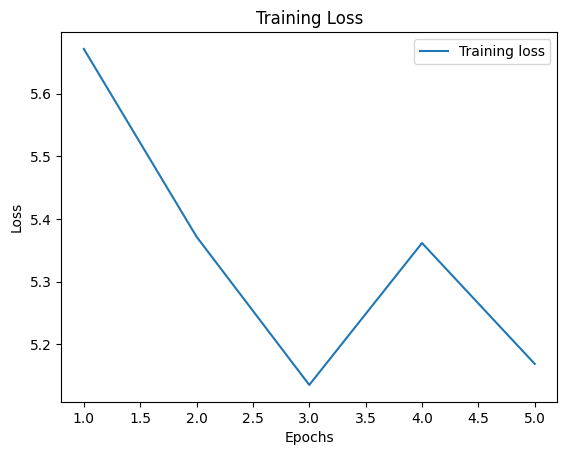

In [ ]:
epcs = jnp.arange(1, epochs+1, step=1)
plt.plot(epcs, train_loss.values(), label='Training loss')
plt.plot(epcs, val_loss.values(), label='Validation loss')

plt.title('Training Loss and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(jnp.arange(0, epochs+1, steps=2))

plt.legend(loc='best')
plt.show()

**Translate custom string**

In [ ]:
def translate(string: str):

    #string = str(string)

    inference_model = eqx.tree_inference(loaded_model, value=True)

    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int)
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

    enc_input_tokens = tokenizer_src.encode(string).ids

    enc_num_padding_tokens = gpt_config["src_seq_len"] - len(enc_input_tokens) - 2

    if enc_num_padding_tokens < 0:
        raise ValueError('Sentence is too long')


    encoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(enc_input_tokens),
        eos_token,
        jnp.repeat(pad_token, enc_num_padding_tokens)
    ])

    assert encoder_input.shape[0] == gpt_config["src_seq_len"]
    encoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0)

    encoder_input = jnp.asarray(encoder_input)
    encoder_mask = jnp.asarray(encoder_mask)
    model_output = greedy_decode(inference_model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len=50)

    print(f'PREDICTED: {tokenizer_tgt.decode(model_output)}')

In [ ]:
translate('I will go home tomorrow, but I think I will arrive late.')

PREDICTED: Je rentre chez lui , mais je crois que je arrivera tard .


## Attention Visualisation